Image loaded and downsampled
Edge detection complete
------------
Applying KMeans clustering
Cloud coverage calculation complete
Cloud density calculation complete
Determining weather indicators


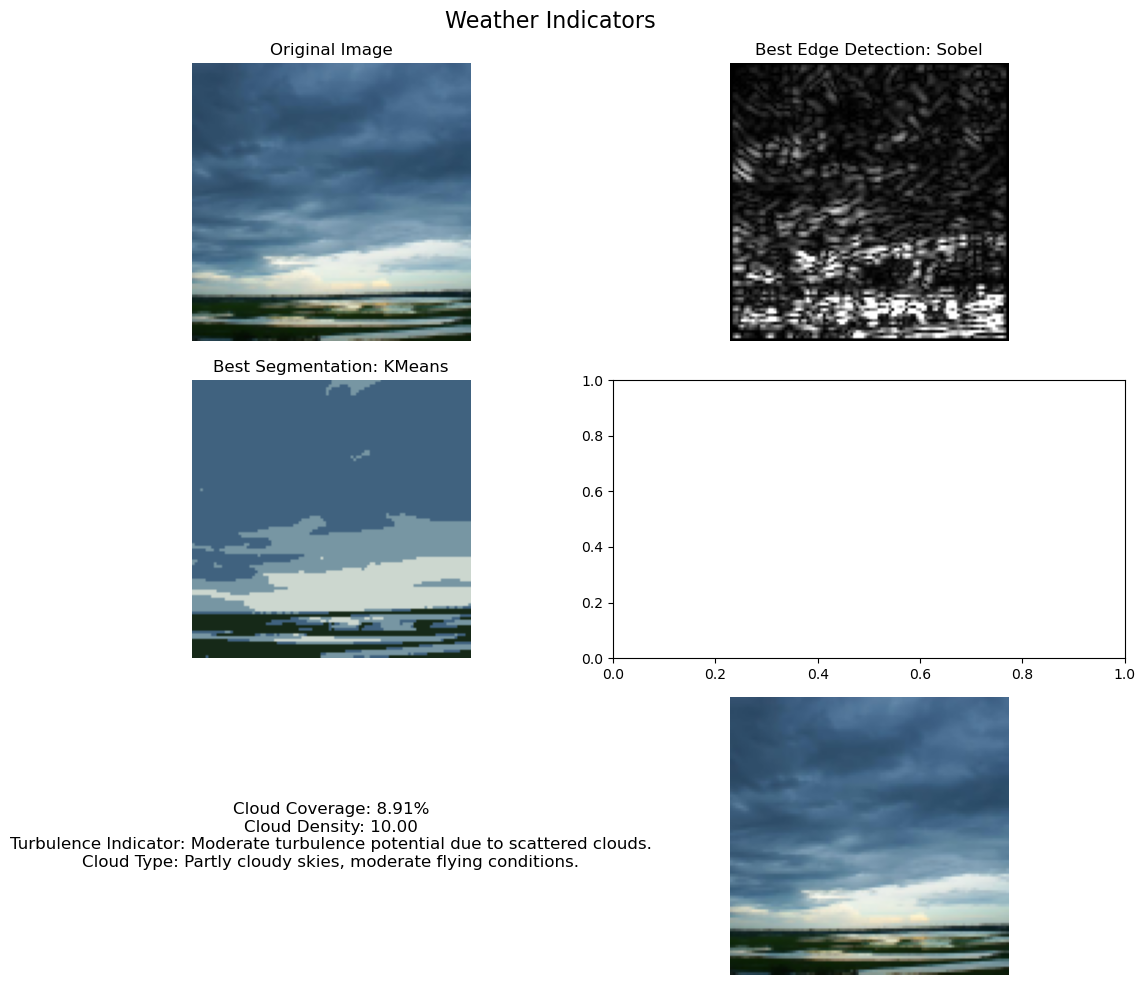

{'cloud_coverage': 8.910034602076125, 'cloud_density': 10, 'turbulence_indicator': 'Moderate turbulence potential due to scattered clouds.', 'cloud_type': 'Partly cloudy skies, moderate flying conditions.'}


In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Step 1: Load Image
def load_image(image_path, scale_percent=20):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image could not be loaded. Check the file path.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Downsample the image
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    
    print("Image loaded and downsampled")
    return image

# Step 2: Edge Detection with Algorithm Selection
def edge_detection(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Apply multiple edge detection algorithms
    edges_canny = cv2.Canny(gray, 50, 150)
    edges_sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 1, ksize=5)
    edges_sobel = cv2.convertScaleAbs(edges_sobel)
    edges_laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    edges_laplacian = cv2.convertScaleAbs(edges_laplacian)
    print("Edge detection complete")

    # Calculate edge strength (number of edge pixels)
    edge_strengths = {
        "Canny": np.sum(edges_canny > 0),
        "Sobel": np.sum(edges_sobel > 0),
        "Laplacian": np.sum(edges_laplacian > 0)
    }
    
    # Select the edge detection method with the highest edge strength
    best_edge_algo = max(edge_strengths, key=edge_strengths.get)
    best_edge_image = eval(f"edges_{best_edge_algo.lower()}")
    
    return best_edge_image, best_edge_algo

# Step 3: Segmentation with KMeans Clustering
def segmentation(image):
    reshaped_image = image.reshape((-1, 3))
    print("Applying KMeans clustering")
    
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=4, random_state=0, verbose=0, n_init='auto')
    labels_kmeans = kmeans.fit_predict(reshaped_image)
    
    # Rebuild segmented image from KMeans clustering
    segmented_image = kmeans.cluster_centers_[labels_kmeans].reshape(image.shape)
    
    return segmented_image.astype(np.uint8), "KMeans"

# Step 4: Cloud Coverage Calculation with Adaptive Thresholding
def calculate_cloud_coverage(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 30, 255])
    mask = cv2.inRange(hsv_image, lower_white, upper_white)
    print("Cloud coverage calculation complete")
    
    # Calculate cloud coverage percentage
    cloud_pixels = np.sum(mask == 255)
    total_pixels = mask.size
    cloud_coverage = (cloud_pixels / total_pixels) * 100 if total_pixels > 0 else 0
    return cloud_coverage

# Step 5: Texture Analysis with GLCM
def texture_analysis(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    glcm = graycomatrix(gray, distances=[5], angles=[0], symmetric=True, normed=True)
    contrast = np.mean(graycoprops(glcm, 'contrast'))
    dissimilarity = np.mean(graycoprops(glcm, 'dissimilarity'))
    correlation = np.mean(graycoprops(glcm, 'correlation'))
    homogeneity = np.mean(graycoprops(glcm, 'homogeneity'))
    return contrast, dissimilarity, correlation, homogeneity

def calculate_cloud_density(contrast, dissimilarity, correlation, homogeneity):
    density = min((contrast + dissimilarity + correlation + homogeneity) / 4, 10)
    print("Cloud density calculation complete")
    return density

# Step 6: Determine Weather Indicators
def weather_indicators(cloud_coverage, cloud_density):
    print("Determining weather indicators")
    if cloud_coverage < 5:
        turbulence_indicator = "Low turbulence potential, clear skies."
        cloud_type = "Clear skies, ideal flying conditions."
    elif cloud_coverage < 20:
        if cloud_density < 0.4:
            turbulence_indicator = "Low turbulence potential, mostly clear."
            cloud_type = "Mostly clear skies, good flying conditions."
        else:
            turbulence_indicator = "Moderate turbulence potential due to scattered clouds."
            cloud_type = "Partly cloudy skies, moderate flying conditions."
    elif cloud_coverage < 50:
        if cloud_density < 1:
            turbulence_indicator = "Moderate turbulence potential, scattered clouds."
            cloud_type = "Partly cloudy skies, manageable flying conditions."
        else:
            turbulence_indicator = "High turbulence potential due to thicker clouds."
            cloud_type = "Mostly cloudy skies, caution advised for flying."
    else:
        turbulence_indicator = "Very high turbulence potential due to dense clouds."
        cloud_type = "Overcast skies, difficult flying conditions."
    
    return turbulence_indicator, cloud_type

# Full Processing Function
def process_cloud_image(image_path):
    image = load_image(image_path)
    
    # Edge detection with best algorithm selection
    best_edges, best_edge_algo = edge_detection(image)
    print("------------")
    
    # Segmentation with KMeans
    best_segmented_image, best_seg_algo = segmentation(image)
    
    # Cloud coverage calculation
    cloud_coverage = calculate_cloud_coverage(image)
    
    # Texture analysis and cloud density
    contrast, dissimilarity, correlation, homogeneity = texture_analysis(best_segmented_image)
    cloud_density = calculate_cloud_density(contrast, dissimilarity, correlation, homogeneity)
    
    # Weather indicators
    turbulence_indicator, cloud_type = weather_indicators(cloud_coverage, cloud_density)
    
    # Display results
    fig, axs = plt.subplots(3, 2, figsize=(12, 10))
    fig.suptitle("Weather Indicators", fontsize=16)
    
    axs[0, 0].imshow(image)
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis("off")
    
    axs[0, 1].imshow(best_edges, cmap="gray")
    axs[0, 1].set_title(f"Best Edge Detection: {best_edge_algo}")
    axs[0, 1].axis("off")
    
    axs[1, 0].imshow(best_segmented_image)
    axs[1, 0].set_title(f"Best Segmentation: {best_seg_algo}")
    axs[1, 0].axis("off")
    
    axs[2, 0].axis("off")
    axs[2, 0].text(0.5, 0.5, f"Cloud Coverage: {cloud_coverage:.2f}%\n"
                             f"Cloud Density: {cloud_density:.2f}\n"
                             f"Turbulence Indicator: {turbulence_indicator}\n"
                             f"Cloud Type: {cloud_type}", 
                   ha="center", va="center", fontsize=12)
    axs[2, 1].imshow(image)
    axs[2, 1].axis("off")
    plt.tight_layout()
    plt.show()
    
    return {
        "cloud_coverage": cloud_coverage,
        "cloud_density": cloud_density,
        "turbulence_indicator": turbulence_indicator,
        "cloud_type": cloud_type
    }

# Example usage for provided images
for img_path in ["33.jpg"]:
    weather_info = process_cloud_image(img_path)
    print(weather_info)
